In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

In [3]:
# 导入数据集
df = pd.read_csv('./AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
# 查看数据
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [5]:
# 查看数据信息
df.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [6]:
# 查看数据字段下的值
for column in df.drop(['auction_id','hour','device_make'],axis=1).columns:
    print(column,'-',df[column].unique())

experiment - ['exposed' 'control']
date - ['2020-07-10' '2020-07-07' '2020-07-05' '2020-07-03' '2020-07-09'
 '2020-07-04' '2020-07-06' '2020-07-08']
platform_os - [6 5 7]
browser - ['Chrome Mobile' 'Chrome Mobile WebView' 'Facebook' 'Mobile Safari'
 'Chrome Mobile iOS' 'Samsung Internet' 'Mobile Safari UI/WKWebView'
 'Chrome' 'Opera Mini' 'Edge Mobile' 'Android' 'Pinterest' 'Opera Mobile'
 'Firefox Mobile' 'Puffin']
yes - [0 1]
no - [0 1]


Text(0.5, 1.0, '对于不同类型样本的计数')

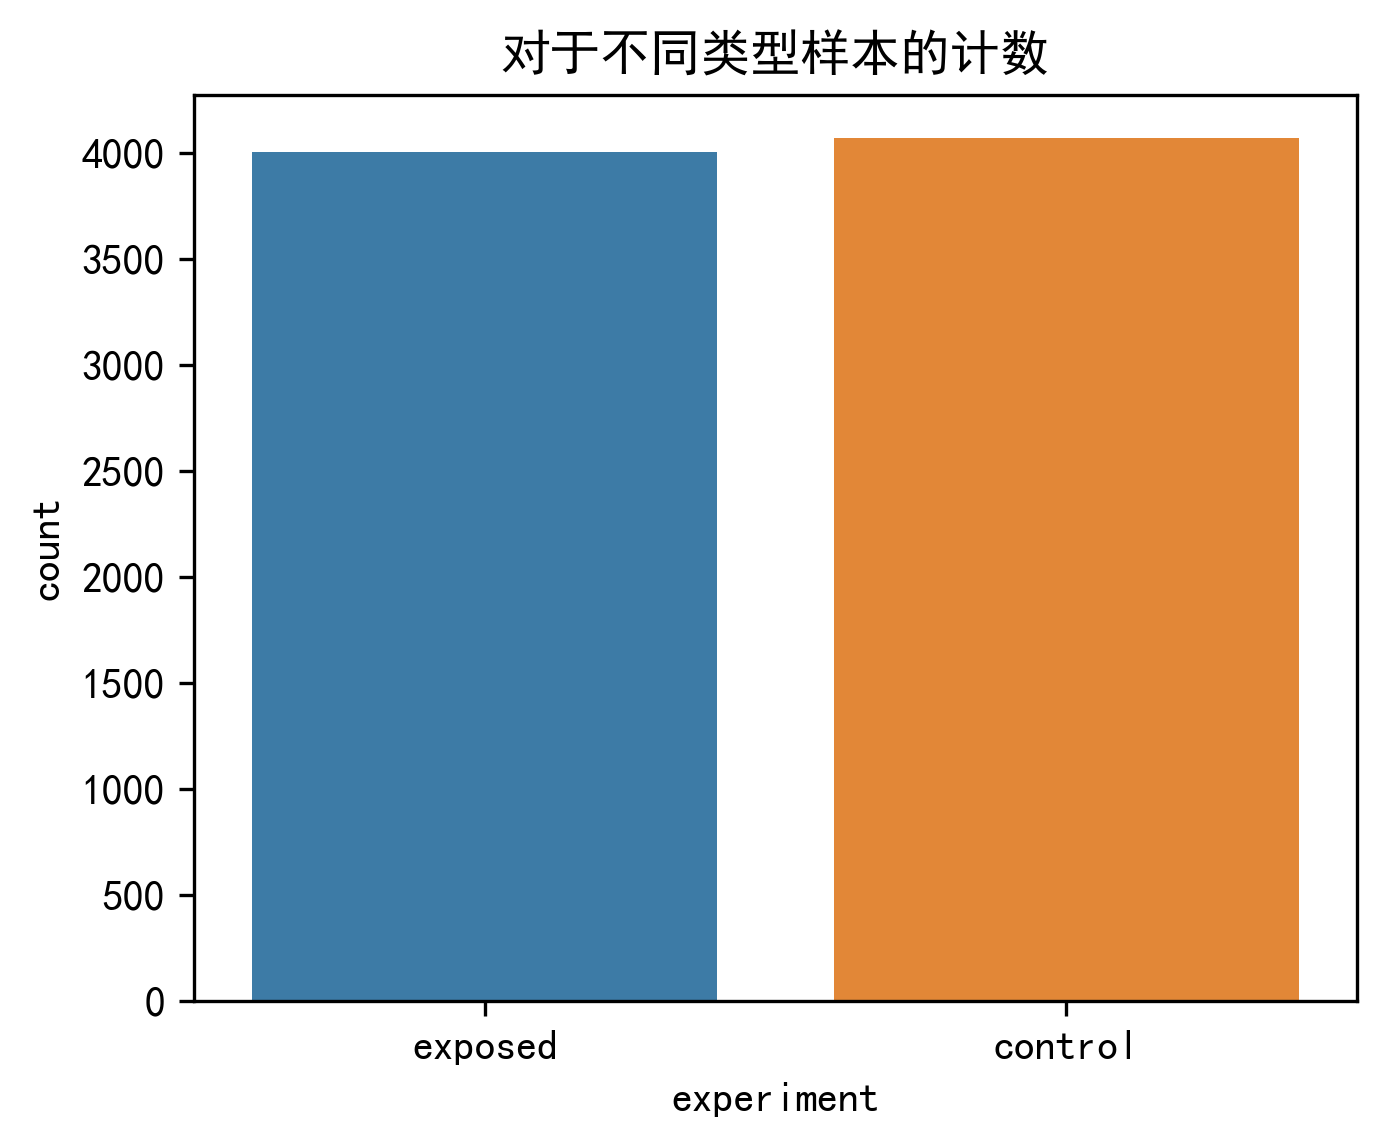

In [7]:
# 查看试验组和对照组的样本容量以及是都均衡
fig,axes = plt.subplots(figsize=(5,4),dpi=300)
sns.countplot(x=df['experiment'],alpha=0.95)
plt.title('对于不同类型样本的计数')

In [8]:
# 计算统计量
control = df[df['experiment']=='control']
exposed = df[df['experiment']=='exposed']

# 计算样本量
total_control = control['auction_id'].count()
total_exposed = exposed['auction_id'].count()

# 计算点击广告的用户数量
clicks_control = control['auction_id'].loc[(control['yes']==1) & (control['no']==0)].count()
clicks_exposed = exposed['auction_id'].loc[(exposed['yes']==1) & (exposed['no']==0)].count()

# 计算广告点击率
p1 = clicks_control / total_control
p2 = clicks_exposed / total_exposed

# 输出
print(f'控制组的样本量：{total_control}\n试验组的样本量：{total_exposed}\n控制组点击广告的用户数量：{clicks_control}\n试验组点击广告的用户数量：{clicks_exposed}\n控制组广告点击率：' + format(p1,'.2%') + '\n试验组广告点击率：' + format(p2,'.2%'))

控制组的样本量：4071
试验组的样本量：4006
控制组点击广告的用户数量：264
试验组点击广告的用户数量：308
控制组广告点击率：6.48%
试验组广告点击率：7.69%


In [9]:
# 封装的代码

class Sample:
    '''
    计算样本量
    https://www.abtasty.com/sample-size-calculator/
    '''

    def sample_size_u(self, u: float, s: float, a: float = 0.05, b: float = 0.2) -> int:
        '''
        已知双样本(A/B)均数，求实验样本量
        :param a: alpha
        :param b: beta
        :param u: 均值的差值
        :param s: 经验标准差
        :return: 样本量
        '''
        n = 2 * pow(((norm.ppf(1 - a / 2) + norm.ppf(1 - b)) / (u / s)), 2)
        return math.ceil(n)

    def sample_size_p(self, p1: float, p2: float, a: float = 0.05, b: float = 0.2) -> int:
        '''
        已知双样本(A/B)频数，求实验样本量
        :param a: alpha
        :param b: beta
        :param p1: 样本的频数，例如点击率50%，次日留存率80%
        :param p2: 样本的频数
        :return: 样本量
        '''
        n = pow((norm.ppf(1 - a / 2) + norm.ppf(1 - b)) / (p1 - p2), 2) * (p1 * (1 - p1) + p2 * (1 - p2))
        return math.ceil(n)


class ABtest_u():
    '''
    双样本双尾均值检验
    '''

    def __init__(self, x1: float, x2: float, s1: float, s2: float, n1: int, n2: int, a: float = 0.05, b: float = 0.2):
        self.x1 = x1  # 对照组均值
        self.x2 = x2  # 测试组均值
        self.s1 = s1  # 对照组标准差
        self.s2 = s2  # 测试组标准差
        self.n1 = n1  # 对照组样本量
        self.n2 = n2  # 测试组样本量
        self.a = a  # alpha
        self.b = b  # beta

    def significance_u(self) -> (int, float, float):
        '''
        双样本双尾均值显著性检验
        '''
        z = (self.x1 - self.x2) / pow(self.s1 ** 2 / self.n1 + self.s2 ** 2 / self.n2, 1 / 2)
        if z > 0:
            p = (1 - norm.cdf(z)) * 2
            if p < self.a:  # 拒绝原假设，接受备选假设
                f = 1
            else:  # 接受原假设
                f = 0
        else:
            p = 2 * norm.cdf(z)
            if p < self.a:  # 拒绝原假设，接受备选假设
                f = 1
            else:  # 接受原假设
                f = 0
        return f, format(z, '.2f'), format(p, '.2f')

    def confidence_u(self) -> tuple:
        '''
        双样本均值置信区间
        '''
        d = norm.ppf(1 - self.a / 2) * pow(self.s1 ** 2 / self.n1 + self.s2 ** 2 / self.n2, 1 / 2)
        floor = -(self.x1 - self.x2 - d)
        ceil = -(self.x1 - self.x2 + d)
        return (format(floor, '.2f'), format(ceil, '.2f'))

    def power_u(self) -> float:
        '''
        双样本均数功效
        '''
        z = abs(self.x1 - self.x2) / pow(self.s1 ** 2 / self.n1 + self.s2 ** 2 / self.n2, 1 / 2) - norm.ppf(
            1 - self.a / 2)
        b = 1 - norm.cdf(z)
        power = 1 - b
        return format(power, '.2%')

    def main(self):
        f, z, p = self.significance_u()
        ci = self.confidence_u()
        power = self.power_u()
        print(f'保留组均值：{self.x1}')
        print(f'测试组均值：{self.x2}')
        print('是否显著：' + ('统计效果显著，拒绝原假设' if f == 1 else '统计效果不显著，不能拒绝原假设'))
        print(f'变化度：' + format((self.x2 - self.x1) / self.x1, '.2%'))
        print(f'置信区间：{ci}')
        print(f'p-value：{p}')
        print(f'功效：{power}')


class ABtest_p():
    '''
    双样本双尾频数检验
    '''

    def __init__(self, p1: float, p2: float, n1: int, n2: int, a: float = 0.05, b: float = 0.2):
        self.p1 = p1
        self.p2 = p2
        self.n1 = n1
        self.n2 = n2
        self.a = a
        self.b = b

    def significance_p(self) -> (int, float, float):
        '''
        双样本双尾频数显著性检验
        '''
        p_pool = (self.n1 * self.p1 + self.n2 * self.p2) / (self.n1 + self.n2)

        z = (self.p1 - self.p2) / pow(p_pool * (1 - p_pool) * (1 / self.n1 + 1 / self.n2), 1 / 2)

        if z > 0:
            p = (1 - norm.cdf(z)) * 2
            if p < self.a:  # 拒绝原假设，接受备选假设
                f = 1
            else:  # 接受原假设
                f = 0
        else:
            p = 2 * norm.cdf(z)
            if p < self.a:  # 拒绝原假设，接受备选假设
                f = 1
            else:  # 接受原假设
                f = 0
        return f, format(z, '.2f'), format(p, '.2f')

    def confidence_p(self) -> tuple:
        '''
        双样本频数置信区间
        '''
        d = norm.ppf(1 - self.a / 2) * pow(self.p1 * (1 - self.p1) / self.n1 + self.p2 * (1 - self.p2) / self.n2, 1 / 2)
        floor = -(self.p1 - self.p2 - d)
        ceil = -(self.p1 - self.p2 + d)
        return (format(floor, '.2%'), format(ceil, '.2%'))

    def power_p(self) -> float:
        '''
        双样本频数功效
        '''
        z = abs(self.p1 - self.p2) / pow(self.p1 * (1 - self.p1) / self.n1 + self.p2 * (1 - self.p2) / self.n2,
                                         1 / 2) - norm.ppf(1 - self.a / 2)
        b = 1 - norm.cdf(z)
        power = 1 - b
        return format(power, '.2%')

    def main(self):
        f, z, p = self.significance_p()
        ci = self.confidence_p()
        power = self.power_p()
        print(f'保留组均值：{self.p1}')
        print(f'测试组均值：{self.p2}')
        print('是否显著：' + ('统计效果显著，拒绝原假设' if f == 1 else '统计效果不显著，不能拒绝原假设'))
        print(f'变化度：' + format((self.p2 - self.p1) / self.p1, '.2%'))
        print(f'置信区间：{ci}')
        print(f'p-value：{p}')
        print(f'功效：{power}')

In [10]:
# 执行代码
test = ABtest_p(p1=p1, p2=p2, n1=total_control, n2=total_exposed)
test.main()

保留组均值：0.06484893146647015
测试组均值：0.07688467299051423
是否显著：统计效果显著，拒绝原假设
变化度：18.56%
置信区间：('2.32%', '0.08%')
p-value：0.04
功效：55.87%


### 结论分析
- 描述统计分析
  控制组的样本量：4071个，广告点击率：6.48%
  试验组的样本量：4006个，广告点击率：7.69%
- 推论统计分析
  - 假设检验
    独立双样本 p-value = 0.04( α = 5% ) ，双尾检验
    统计显著，拒绝零假设，接受备择假设。即：智能广告和普通广告的点击率不同，两种广告的点击率是有差别的
  - 置信区间
    两个独立样本均值差值的置信区间，置信水平 95%，CI = (2.32%, 0.08%)
    控制组的点击率小于试验组，且通过读取置信区间的数值，区间边界值均为负值，证明控制组的点击率显著小于实验组，即 智能广告的点击率不同显著小于普通广告
- 功效
  power = 55.87%，效果不显著，结论：不建议大规模推广智能广告